https://www.statsmodels.org/stable/gettingstarted.html

https://patsy.readthedocs.io/en/latest/quickstart.html

https://blog.csdn.net/wuzlun/article/details/80287583

https://seaborn.pydata.org/tutorial/categorical.html

contextual bandit：reward是context（action和state）的函数

In [1]:
from patsy import dmatrices
import statsmodels.api as sm
# from scipy.stats import pearsonr as ps
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts import options as opts
from pyecharts.charts import Pie, Bar

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.discrete.discrete_model import Logit

# ===
`Supervision_Level_First`作为action
   * 看和其他feature的相关性
   * 谁会拿到high/specialized？
  
-----------
逻辑：
* 出狱前的数据项（2\~33）是observation
* 出狱时的supervision level（8）是action
* 出狱后的情况（34\~53）是reward（主要是再犯罪情况）
  
# ===

# 数据读入、观察

In [3]:
data = pd.read_csv('NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
Y = 'Supervision_Level_First'
data.head()

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.0,0.000000,0.0,0.488562,0.447610,False,False,False,False,False
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.0,0.000000,0.0,0.425234,2.000000,False,True,False,False,True
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.0,0.166667,0.0,0.000000,0.000000,False,True,False,True,False
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.0,0.000000,0.0,1.000000,0.718996,False,False,False,False,False
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.0,0.058824,0.0,0.203562,0.929389,False,True,True,False,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                18028 non-null  object 
 1   Gender                            18028 non-null  object 
 2   Race                              18028 non-null  object 
 3   Age_at_Release                    18028 non-null  object 
 4   Residence_PUMA                    18028 non-null  int64  
 5   Gang_Affiliated                   15811 non-null  object 
 6   Supervision_Risk_Score_First      17698 non-null  float64
 7   Supervision_Level_First           16816 non-null  object 
 8   Education_Level                   18028 non-null  object 
 9   Dependents                        18028 non-null  object 
 10  Prison_Offense                    15707 non-null  object 
 11  Prison_Years                      18028 non-null  object 
 12  Prio

In [4]:
data = data.rename(columns={'_v1':'Prior_Arrest_Episodes_PPViolationCharges', 
                            '_v2':'Prior_Conviction_Episodes_PPViolationCharges', 
                            '_v3':'Prior_Conviction_Episodes_DVCharges', 
                            '_v4':'Prior_Conviction_Episodes_GunCharges'})
data = data.dropna(subset=['Supervision_Level_First'])

In [34]:
# 查看不同supervision level的人数
d = data.groupby(Y)['ID'].agg({'count'}).reset_index()
d

,Supervision_Level_First,count
0,High,4903
1,Specialized,4942
2,Standard,6971


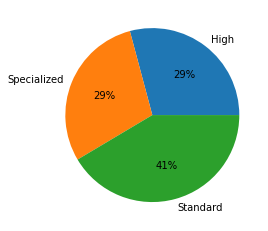

In [51]:
plt.figure()
plt.pie(d['count'], labels=d['Supervision_Level_First'], autopct = '%0.0f%%')
plt.show()

In [123]:
def plot_different_level_pie(colname):
    d = data.groupby([Y, colname])['ID'].agg({'count'}).reset_index()

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    for i, t in enumerate(['Standard', 'High', 'Specialized']):
        dt = d[d[Y] == t]
        ax = [ax1, ax2, ax3][i]
        ax.pie(dt['count'], labels=dt[colname], autopct = '%0.0f%%')
        ax.set_title(t)
    plt.show()

# 1. 入狱前/狱中的特征

-------------------------
## important feature (refer to the results of LR)

'Age_at_Release','Gang_Affiliated', 'Prison_Years', 'Prison_Offense', 'Percent_Days_Employed', 'Employment_Exempt'

Condition_MH_SA, Condition_Cog_Ed, Condition_Other

Residence_PUMA

### Supervision_Risk_Score_First

各level的平均，
Risk_Score是specialize > high > std ？

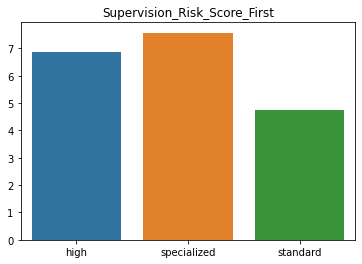

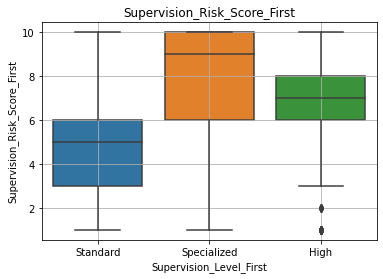

In [6]:
plt.figure()
y = data.groupby(Y).agg({'Supervision_Risk_Score_First': 'mean'}).reset_index(drop=True)
sns.barplot(x=['high', 'specialized', 'standard'], 
            y=y['Supervision_Risk_Score_First'].tolist())
plt.title('Supervision_Risk_Score_First')

plt.figure()
sns.boxplot(x=Y, y='Supervision_Risk_Score_First', data=data)
plt.grid()
plt.title('Supervision_Risk_Score_First')

plt.show()

In [80]:
tt = data[[Y, 'Supervision_Risk_Score_First']]
tt = pd.get_dummies(tt)
tt.corr()['Supervision_Risk_Score_First']

Supervision_Risk_Score_First           1.000000
Supervision_Level_First_High           0.202522
Supervision_Level_First_Specialized    0.391204
Supervision_Level_First_Standard      -0.443757
Name: Supervision_Risk_Score_First, dtype: float64

high和specialized都和score正相关，standard和score负相关。

<Figure size 1080x576 with 0 Axes>

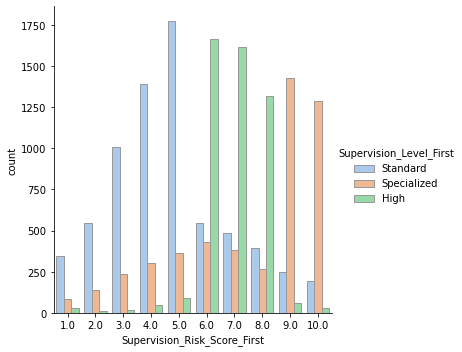

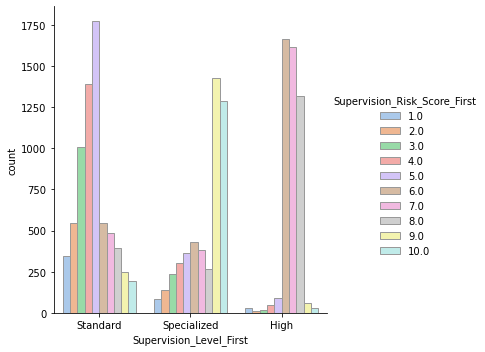

In [110]:
plt.figure(figsize=(15, 8))
sns.catplot(x='Supervision_Risk_Score_First', hue=Y, kind="count", 
            palette="pastel", edgecolor=".6", data=data)
sns.catplot(hue='Supervision_Risk_Score_First', x=Y, kind="count", 
            palette="pastel", edgecolor=".6", data=data)
plt.show()

关联性比较明显：1\~5分集中在standard，6\~8分集中在high，9\~10分集中在specialized

high的集中度比较明显

### PUMA

In [77]:
d = data.groupby([Y, 'Residence_PUMA'])['ID'].agg({'count'}).reset_index()

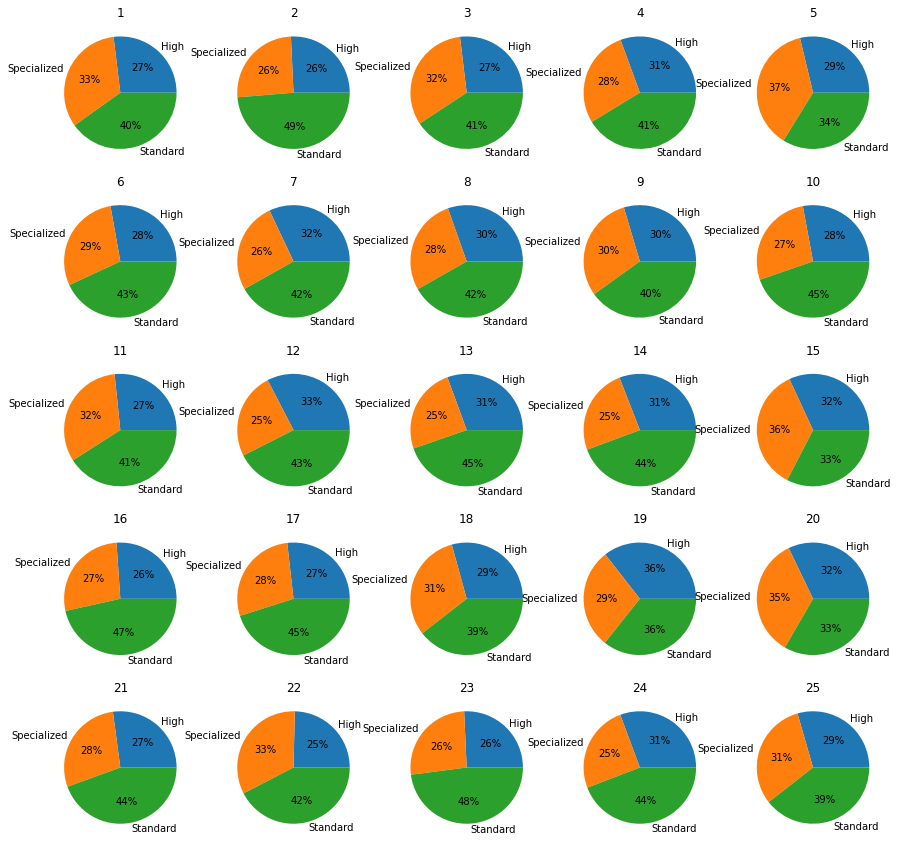

In [76]:
plt.figure(figsize=(15, 15))
for puma in range(1, 26):
    pumadata = d[d.Residence_PUMA == puma]
    plt.subplot(5, 5, puma)
    plt.pie(pumadata['count'], labels=pumadata[Y], autopct='%0.0f%%')
    plt.title(puma)
plt.show()

### gender

<Figure size 1080x576 with 0 Axes>

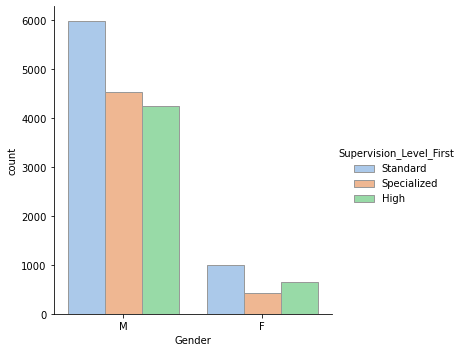

In [54]:
plt.figure(figsize=(15, 8))
sns.catplot(x='Gender', hue=Y, kind="count", palette="pastel", edgecolor=".6", data=data)
plt.show()

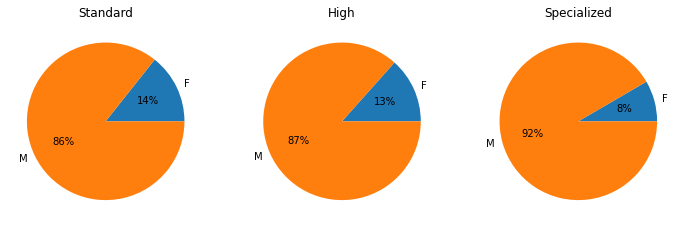

In [124]:
plot_different_level_pie('Gender')

### age at release

<Figure size 1080x576 with 0 Axes>

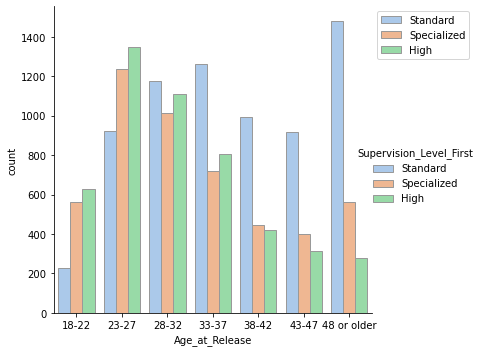

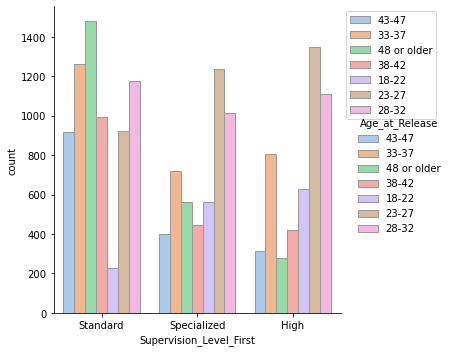

In [22]:
plt.figure(figsize=(15, 8))
sns.catplot(x='Age_at_Release', hue=Y, kind="count", order=['18-22', '23-27', '28-32', '33-37', '38-42', '43-47', '48 or older'], 
            palette="pastel", edgecolor=".6", data=data)
plt.legend(loc=2, bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()
sns.catplot(hue='Age_at_Release', x=Y, kind="count", 
            palette="pastel", edgecolor=".6", data=data)
plt.legend(loc=2, bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()
plt.show()

standard的年龄分布比较均匀（18\~22的比较少），另外两个在23-37有比较明显的尖峰

### Gang_Affiliated

<Figure size 1080x576 with 0 Axes>

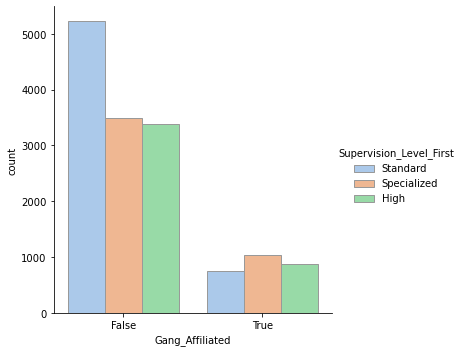

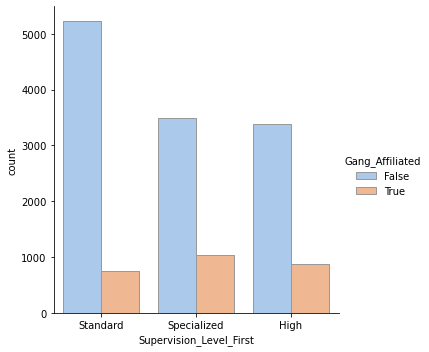

In [27]:
plt.figure(figsize=(15, 8))

sns.catplot(x='Gang_Affiliated', hue=Y, kind="count", palette="pastel", edgecolor=".6", data=data)

sns.catplot(hue='Gang_Affiliated', x=Y, kind="count", palette="pastel", edgecolor=".6", data=data)

plt.show()

其实都差不多？standard的False明显占比更多一点，另外两个没什么区别

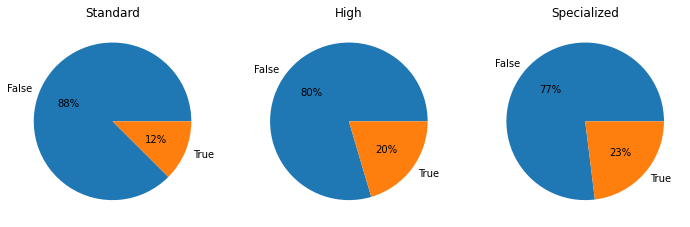

In [125]:
plot_different_level_pie('Gang_Affiliated')

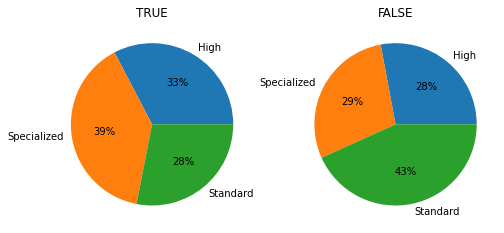

In [83]:
d = data.groupby([Y, 'Gang_Affiliated'])['ID'].agg({'count'}).reset_index()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

dt = d[d['Gang_Affiliated'] == True]
ax1.pie(dt['count'], labels=dt[Y], autopct = '%0.0f%%')
ax1.set_title('TRUE')

dt = d[d['Gang_Affiliated'] == False]
ax2.pie(dt['count'], labels=dt[Y], autopct = '%0.0f%%')
ax2.set_title('FALSE')

plt.show()

### Prison_Offense

<Figure size 1080x576 with 0 Axes>

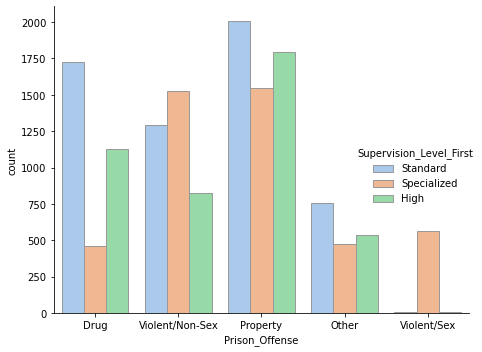

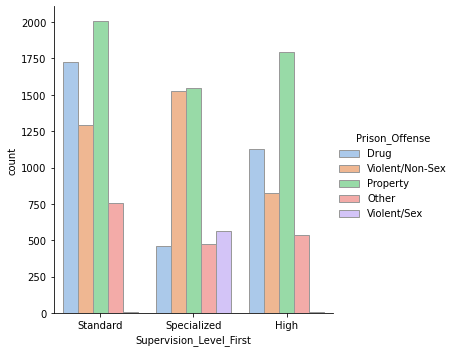

In [5]:
plt.figure(figsize=(15, 8))

sns.catplot(x='Prison_Offense', hue=Y, kind="count", palette="pastel", edgecolor=".6", data=data)
plt.tight_layout()

sns.catplot(hue='Prison_Offense', x=Y, kind="count", palette="pastel", edgecolor=".6", data=data)

plt.show()

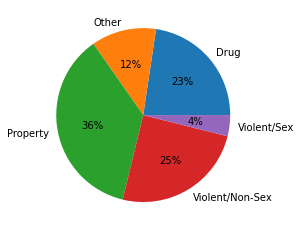

In [144]:
d = data.groupby('Prison_Offense')['ID'].agg({'count'}).reset_index()
plt.figure()
plt.pie(d['count'], labels=d['Prison_Offense'], autopct = '%0.0f%%')
plt.show()

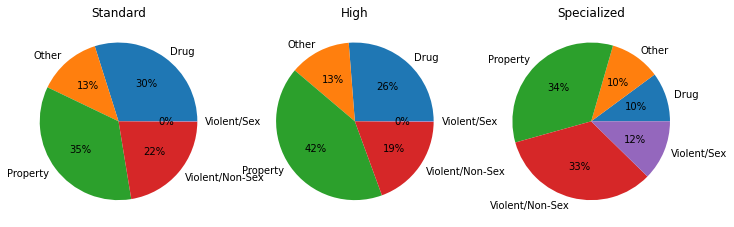

In [142]:
plot_different_level_pie('Prison_Offense')

有过性暴力犯罪的基本都归为了Specialized！

In [9]:
data[data['Prison_Offense'] == 'Violent/Sex'][Y].value_counts()

Specialized    565
High             5
Standard         5
Name: Supervision_Level_First, dtype: int64

#### observe一下

In [141]:
data[(data['Prison_Offense'] == 'Violent/Sex') & (data['Gender'] != 'M')]
# 没有女性哈

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3


In [83]:
tt1 = data[(data['Prison_Offense'] == 'Violent/Sex') & (data[Y] == 'Standard')].loc[:, 'Race':'Condition_Other']
tt2 = data[(data['Prison_Offense'] == 'Violent/Sex') & (data[Y] == 'High')].loc[:, 'Race':'Condition_Other']
tt3 = data[(data['Prison_Offense'] == 'Violent/Sex') & (data[Y] == 'Specialized')].loc[:, 'Race':'Condition_Other']

cols = tt1.loc[:, 'Race':'Prison_Years'].columns.tolist()
cols.remove('Residence_PUMA')
cols.remove('Prison_Offense')
cols.remove('Supervision_Risk_Score_First')
cols.remove(Y)

In [93]:
tt1.loc[:, cols]  # Standard

,Race,Age_at_Release,Gang_Affiliated,Education_Level,Dependents,Prison_Years
617,WHITE,48 or older,False,Less than HS diploma,0,More than 3 years
1731,WHITE,43-47,False,At least some college,3 or more,More than 3 years
2037,WHITE,48 or older,False,At least some college,3 or more,More than 3 years
2061,WHITE,48 or older,False,High School Diploma,3 or more,More than 3 years
7181,WHITE,28-32,False,High School Diploma,0,More than 3 years


In [94]:
tt2.loc[:, cols]  # High

,Race,Age_at_Release,Gang_Affiliated,Education_Level,Dependents,Prison_Years
41,BLACK,38-42,False,High School Diploma,0,1-2 years
713,BLACK,33-37,False,High School Diploma,1,More than 3 years
8601,WHITE,38-42,False,At least some college,3 or more,More than 3 years
13458,WHITE,43-47,False,At least some college,2,More than 3 years
14498,WHITE,33-37,False,High School Diploma,0,More than 3 years


In [95]:
for c in cols:
    print(tt3[c].value_counts())  # Specialized
    print('=' * 40)

WHITE    328
BLACK    237
Name: Race, dtype: int64
48 or older    136
28-32           97
23-27           92
43-47           75
33-37           73
38-42           52
18-22           40
Name: Age_at_Release, dtype: int64
False    515
True      50
Name: Gang_Affiliated, dtype: int64
High School Diploma      258
Less than HS diploma     167
At least some college    140
Name: Education_Level, dtype: int64
0            194
3 or more    180
1            105
2             86
Name: Dependents, dtype: int64
More than 3 years            320
Greater than 2 to 3 years    122
1-2 years                     90
Less than 1 year              33
Name: Prison_Years, dtype: int64


#### 这俩看不出什么东西

In [91]:
tt1.loc[:, 'Prior_Revocations_Parole':'Prior_Revocations_Probation']

,Prior_Revocations_Parole,Prior_Revocations_Probation
617,False,False
1731,True,False
2037,False,False
2061,False,False
7181,False,False


In [92]:
tt2.loc[:, 'Prior_Revocations_Parole':'Prior_Revocations_Probation']

,Prior_Revocations_Parole,Prior_Revocations_Probation
41,True,False
713,False,False
8601,False,False
13458,False,False
14498,False,False


In [90]:
for c in ['Prior_Revocations_Parole', 'Prior_Revocations_Probation']:
    print(tt3[c].value_counts())
    print('=' * 40)

False    551
True      14
Name: Prior_Revocations_Parole, dtype: int64
False    483
True      82
Name: Prior_Revocations_Probation, dtype: int64


### Prison_Years

<Figure size 1080x576 with 0 Axes>

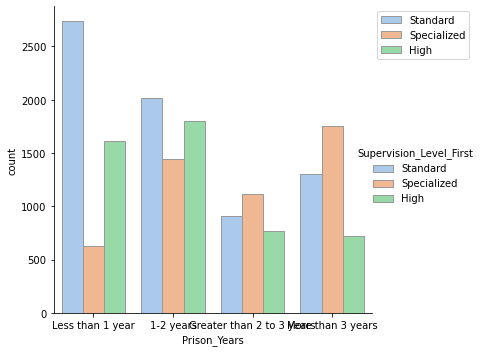

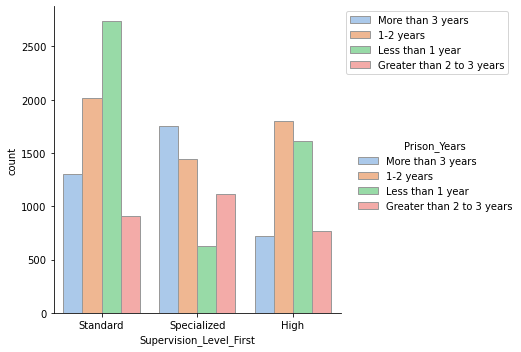

In [20]:
plt.figure(figsize=(15, 8))

sns.catplot(x='Prison_Years', hue=Y, kind="count", order=['Less than 1 year', '1-2 years', 'Greater than 2 to 3 years', 'More than 3 years'],
            palette="pastel", edgecolor=".6", data=data)
plt.legend(loc=2, bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()

sns.catplot(hue='Prison_Years', x=Y, kind="count", palette="pastel", edgecolor=".6", data=data)
plt.legend(loc=2, bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()

plt.show()

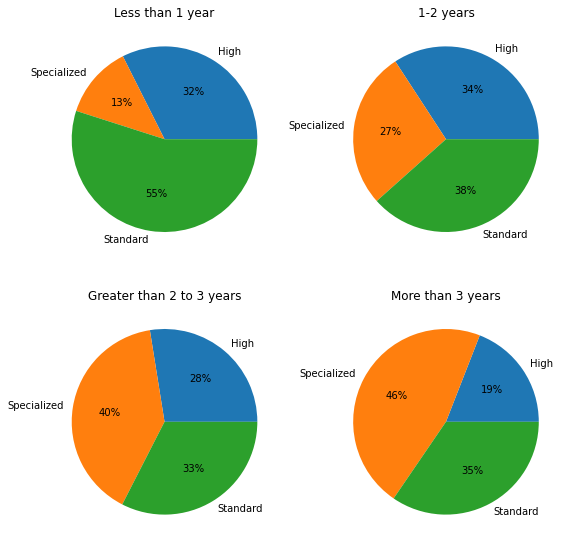

In [87]:
d = data.groupby([Y, 'Prison_Years'])['ID'].agg({'count'}).reset_index()

plt.figure(figsize=(8, 8))
for i, y in enumerate(['Less than 1 year', '1-2 years', 'Greater than 2 to 3 years', 'More than 3 years']):
    ydata = d[d['Prison_Years'] == y]
    plt.subplot(2, 2, i+1)
    plt.pie(ydata['count'], labels=ydata[Y], autopct='%0.0f%%')
    plt.title(y)
plt.tight_layout()
plt.show()

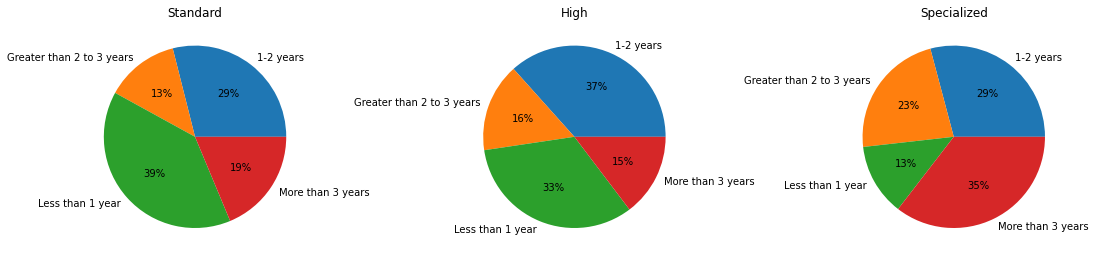

In [90]:
d = data.groupby([Y, 'Prison_Years'])['ID'].agg({'count'}).reset_index()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i, t in enumerate(['Standard', 'High', 'Specialized']):
    dt = d[d[Y] == t]
    ax = [ax1, ax2, ax3][i]
    ax.pie(dt['count'], labels=dt['Prison_Years'], autopct = '%0.0f%%')
    ax.set_title(t)
plt.tight_layout()
plt.show()

### Prior Criminal/Supervision History

In [8]:
data.columns[12: 30] 

Index(['Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DVCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation'],
      dtype='object')

#### Conviction: Felony & Misdemeanor

In [31]:
data.Prior_Conviction_Episodes_Felony.value_counts()

0            5093
1            4589
3 or more    4298
2            2836
Name: Prior_Conviction_Episodes_Felony, dtype: int64

In [49]:
data.Prior_Conviction_Episodes_Misd.value_counts()  # misdemeanor

0            5302
4 or more    3783
1            3499
2            2485
3            1747
Name: Prior_Conviction_Episodes_Misd, dtype: int64

<Figure size 1080x576 with 0 Axes>

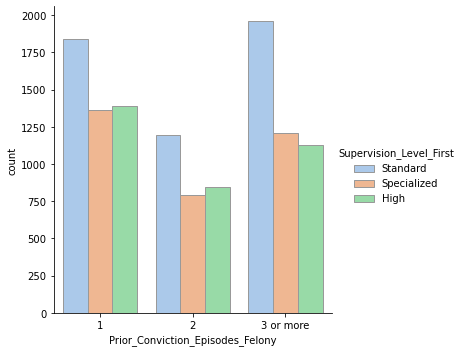

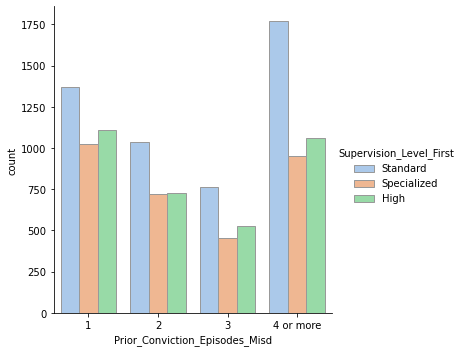

In [48]:
plt.figure(figsize=(15, 8))

sns.catplot(x='Prior_Conviction_Episodes_Felony', hue=Y, kind="count", order=['1', '2', '3 or more'], 
            palette="pastel", edgecolor=".6", data=data)

# sns.catplot(hue='Prior_Conviction_Episodes_Felony', x=Y, kind="count", palette="pastel", edgecolor=".6", data=data)
sns.catplot(x='Prior_Conviction_Episodes_Misd', hue=Y, kind="count", order=['1', '2', '3', '4 or more'], 
            palette="pastel", edgecolor=".6", data=data)

plt.show()

standard的Felony还多一点也太奇怪了吧→_→

不过综合来看好像是不太重要的特征。回归结果里这俩也不是很重要

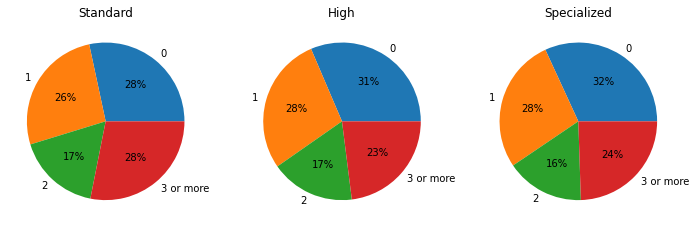

In [132]:
plot_different_level_pie('Prior_Conviction_Episodes_Felony')

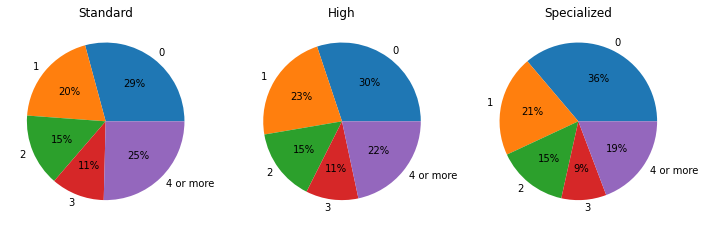

In [133]:
plot_different_level_pie('Prior_Conviction_Episodes_Misd')

#### Conviction

似乎只有Drug比较有区别（所以放到了第一个）

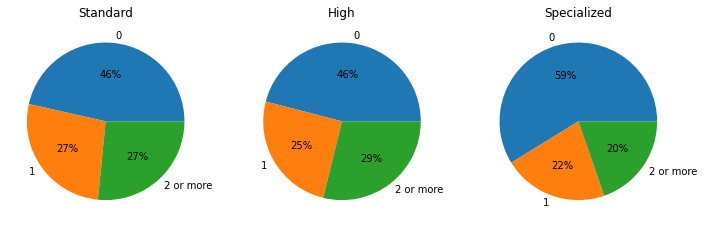

In [136]:
data.Prior_Conviction_Episodes_Drug.value_counts()  
plot_different_level_pie('Prior_Conviction_Episodes_Drug')

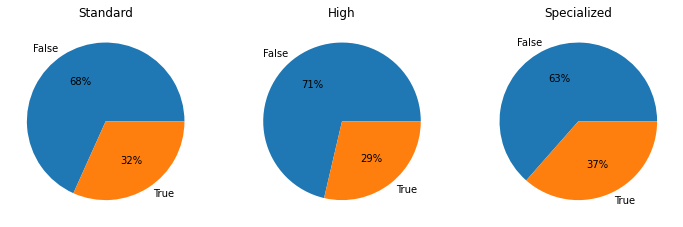

In [134]:
data.Prior_Conviction_Episodes_Viol.value_counts() # violent
plot_different_level_pie('Prior_Conviction_Episodes_Viol')

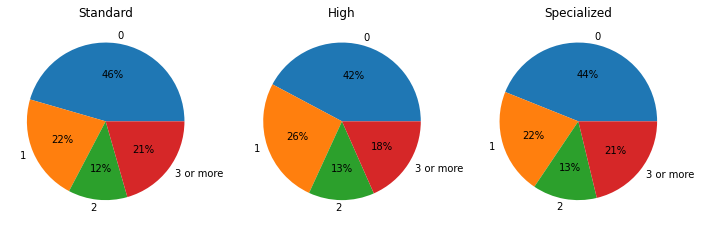

In [135]:
data.Prior_Conviction_Episodes_Prop.value_counts()  # property
plot_different_level_pie('Prior_Conviction_Episodes_Prop')

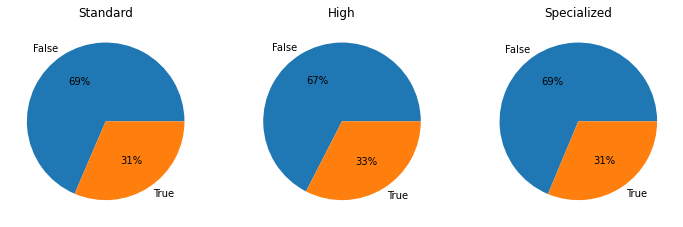

In [137]:
data.Prior_Conviction_Episodes_PPViolationCharges.value_counts()  # probation/parole violation
plot_different_level_pie('Prior_Conviction_Episodes_PPViolationCharges')

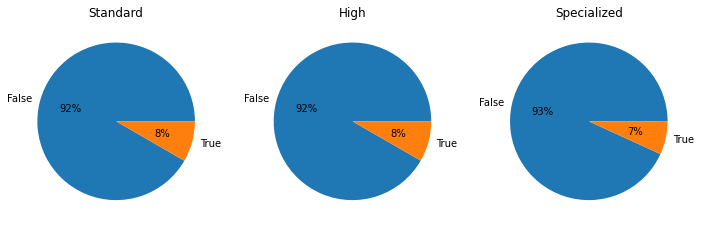

In [138]:
data.Prior_Conviction_Episodes_DVCharges.value_counts()  # domestic violence
plot_different_level_pie('Prior_Conviction_Episodes_DVCharges')

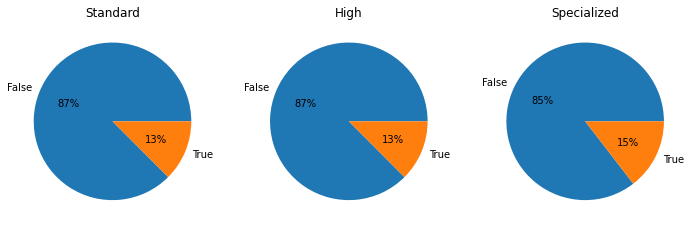

In [139]:
data.Prior_Conviction_Episodes_GunCharges.value_counts()
plot_different_level_pie('Prior_Conviction_Episodes_GunCharges')

### Condition

Condition_MH_SA                 
Condition_Cog_Ed        
Condition_Other


 Condition_MH_SA :



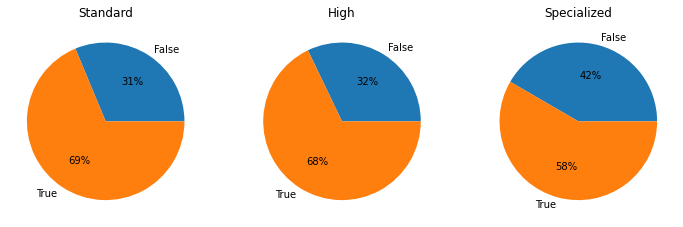


 Condition_Cog_Ed :



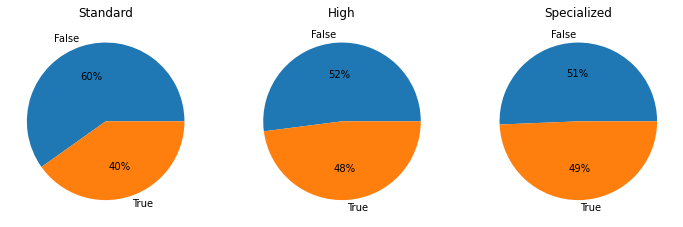


 Condition_Other :



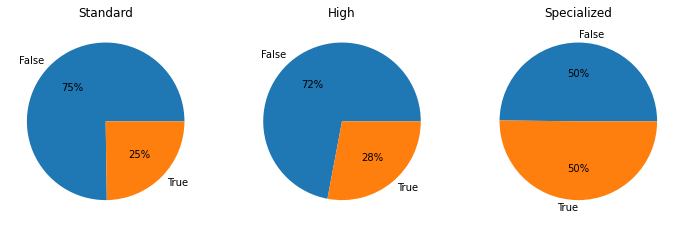

In [131]:
for col in ['Condition_MH_SA', 'Condition_Cog_Ed', 'Condition_Other']:
    print('\n', col, ':\n')
    plot_different_level_pie(col)

### 瞎猜

In [4]:
cols = [Y, 'Age_at_Release','Gang_Affiliated', 'Prison_Years', 'Dependents', 'Percent_Days_Employed', 'Employment_Exempt']
data_intui = data[cols]
for c in [Y, 'Age_at_Release','Gang_Affiliated', 'Dependents', 'Employment_Exempt']:
    data_intui[c] = data_intui[c].astype("category")
data_intui

,Supervision_Level_First,Age_at_Release,Gang_Affiliated,Prison_Years,Dependents,Percent_Days_Employed,Employment_Exempt
0,Standard,43-47,False,More than 3 years,3 or more,0.488562,False
1,Specialized,33-37,False,More than 3 years,1,0.425234,False
2,High,48 or older,False,1-2 years,3 or more,0.000000,False
3,High,38-42,False,1-2 years,1,1.000000,False
4,Specialized,33-37,False,1-2 years,3 or more,0.203562,False
...,...,...,...,...,...,...,...
18023,Standard,23-27,False,More than 3 years,1,0.189507,False
18024,Standard,38-42,False,More than 3 years,3 or more,0.757098,False
18025,Standard,33-37,False,More than 3 years,3 or more,0.711138,False
18026,Standard,33-37,NaN,More than 3 years,3 or more,0.000000,True


In [14]:
data_intui.Prison_Years.value_counts()

1-2 years                    5629
Less than 1 year             5622
More than 3 years            3842
Greater than 2 to 3 years    2935
Name: Prison_Years, dtype: int64

In [15]:
data_intui.Dependents.value_counts()

0            5599
3 or more    5437
1            3751
2            3241
Name: Dependents, dtype: int64

In [17]:
pd.DataFrame(data_intui.Prison_Years.value_counts()).reset_index()

,index,Prison_Years
0,1-2 years,5629
1,Less than 1 year,5622
2,More than 3 years,3842
3,Greater than 2 to 3 years,2935


In [5]:
corr = pd.get_dummies(data_intui).corr()
corr[['Supervision_Level_First_High', 'Supervision_Level_First_Specialized', 'Supervision_Level_First_Standard']]

,Supervision_Level_First_High,Supervision_Level_First_Specialized,Supervision_Level_First_Standard
Percent_Days_Employed,-0.007207,0.040139,-0.029334
Supervision_Level_First_High,1.000000,-0.375603,-0.485300
Supervision_Level_First_Specialized,-0.375603,1.000000,-0.487952
Supervision_Level_First_Standard,-0.485300,-0.487952,1.000000
Age_at_Release_18-22,0.105550,0.074626,-0.139807
Age_at_Release_23-27,0.114599,0.077402,-0.135266
Age_at_Release_28-32,0.054508,0.021349,-0.045941
Age_at_Release_33-37,-0.001712,-0.033008,0.033642
Age_at_Release_38-42,-0.052656,-0.043659,0.073055
Age_at_Release_43-47,-0.079259,-0.043898,0.073636


# 2 出狱后（监督结果&再犯罪情况）
`Recidivism Measures`的四个字段作为reward

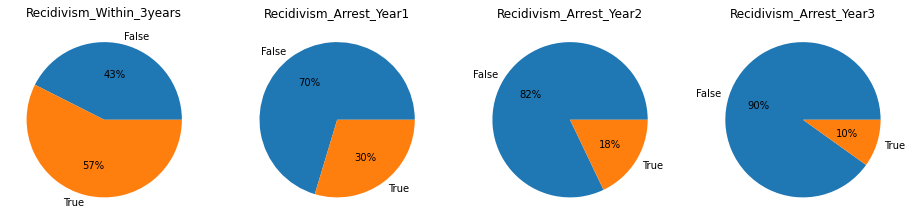

In [11]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
for i, Y in enumerate(data.columns[33:][-4:]):
    dt = data.groupby([Y])['ID'].agg({'count'}).reset_index()
    ax = [ax1, ax2, ax3, ax4][i]
    ax.pie(dt['count'], labels=dt[Y], autopct = '%0.0f%%')
    ax.set_title(Y)
plt.show()

In [24]:
len(data[(data['Recidivism_Arrest_Year3']==True) | (data['Recidivism_Arrest_Year2']==True) | (data['Recidivism_Arrest_Year1']==True)])

9660

In [25]:
len(data[(data['Recidivism_Within_3years']==True)])

9660

In [26]:
len(data[(data['Recidivism_Arrest_Year2']==True)])

3012

In [27]:
len(data[(data['Recidivism_Arrest_Year3']==True)])

1663

In [26]:
data.columns[33:] 

Index(['Violations_ElectronicMonitoring', 'Violations_Instruction',
       'Violations_FailToReport', 'Violations_MoveWithoutPermission',
       'Delinquency_Reports', 'Program_Attendances',
       'Program_UnexcusedAbsences', 'Residence_Changes',
       'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year',
       'Employment_Exempt', 'Recidivism_Within_3years',
       'Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2',
       'Recidivism_Arrest_Year3'],
      dtype='object')

* 看和`Supervision_Level_First`的关系

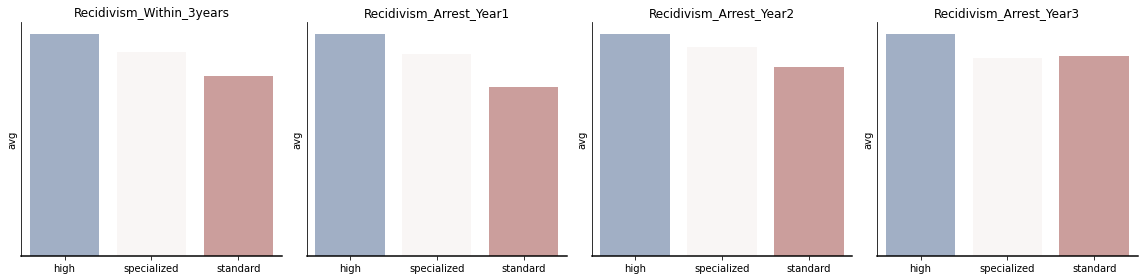

In [91]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4), sharex=True)

y0 = data.groupby(Y).agg({'Recidivism_Within_3years': 'mean'})
sns.barplot(x=['high', 'specialized', 'standard'], 
            y=y0['Recidivism_Within_3years'].tolist(), palette="vlag", ax=ax0)
ax0.axhline(0, color="k", clip_on=False)
ax0.set_ylabel("avg")
ax0.set_title('Recidivism_Within_3years')

y1 = data.groupby(Y).agg({'Recidivism_Arrest_Year1': 'mean'})
sns.barplot(x=['high', 'specialized', 'standard'], 
            y=y1['Recidivism_Arrest_Year1'].tolist(), palette="vlag", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("avg")
ax1.set_title('Recidivism_Arrest_Year1')

# Center the data to make it diverging
y2 = data.groupby(Y).agg({'Recidivism_Arrest_Year2': 'mean'})
sns.barplot(x=['high', 'specialized', 'standard'], 
            y=y2['Recidivism_Arrest_Year2'].tolist(), palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("avg")
ax2.set_title('Recidivism_Arrest_Year2')

# Randomly reorder the data to make it qualitative
y3 = data.groupby(Y).agg({'Recidivism_Arrest_Year3': 'mean'})
sns.barplot(x=['high', 'specialized', 'standard'], 
            y=y3['Recidivism_Arrest_Year3'].tolist(), palette="vlag", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("avg")
ax3.set_title('Recidivism_Arrest_Year3')

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.show()

再犯罪率是high最高


 Recidivism_Within_3years :



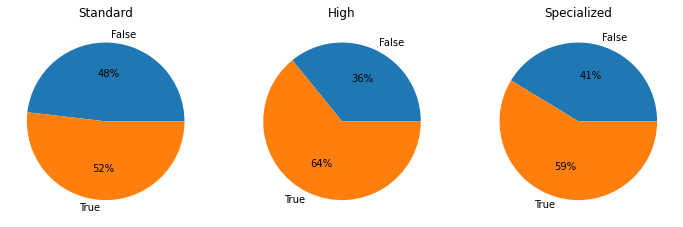


 Recidivism_Arrest_Year1 :



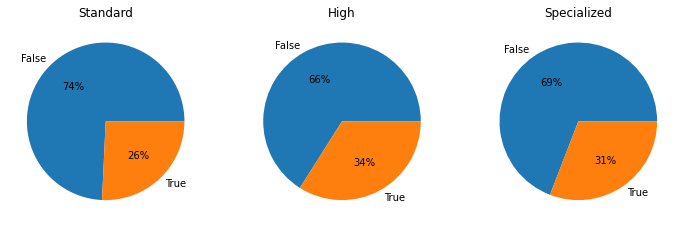


 Recidivism_Arrest_Year2 :



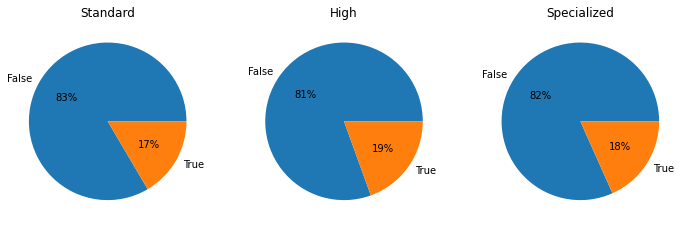


 Recidivism_Arrest_Year3 :



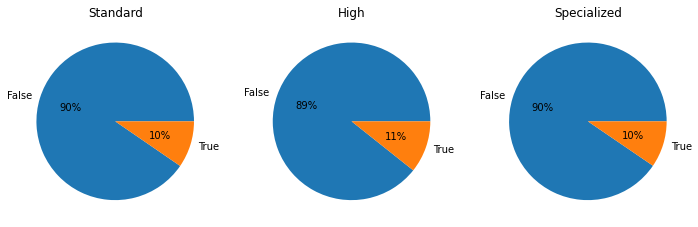

In [130]:
for col in data.columns[49:]:
    print('\n', col, ':\n')
    plot_different_level_pie(col)

**相关系数：**

(没啥相关性的样子)

In [121]:
dd = data[list(data.columns[49:])+[Y]]
pd.get_dummies(dd).corr()[list(data.columns[49:])].iloc[4:]

,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3
Supervision_Level_First_High,0.086923,0.060893,0.026206,0.017148
Supervision_Level_First_Specialized,0.016384,0.017143,0.006745,-0.007755
Supervision_Level_First_Standard,-0.095340,-0.072029,-0.030414,-0.008649


# 分level查看数据

In [38]:
data['Dependents'] = data.Dependents.str.replace('3 or more', '3').astype('int')
data_h, data_spc, data_std = data[data[Y] == 'High'], data[data[Y] == 'Specialized'], data[data[Y] == 'Standard']

In [39]:
len(data_h[data_h.Gender=='M'])

4246

In [40]:
statistics = {'M Ratio': [], 'Black Ratio': [], 'Gang Affiliated': [], 'Dependents': [], 'Percent Days Employed': [], 'Employment Exempt': []}
for df in [data_h, data_spc, data_std]:
    statistics['M Ratio'].append(len(df[df.Gender=='M']) / len(df))   # 男性占比
    statistics['Black Ratio'].append(len(df[df.Race=='BLACK']) / len(df))  # 黑人占比
    statistics['Gang Affiliated'].append(len(df[df.Gang_Affiliated==True]) / len(df))  # 黑帮人数占比
    statistics['Dependents'].append(np.mean(df.Dependents))   # 亲属人数（均值）
    statistics['Percent Days Employed'].append(np.mean(df.Percent_Days_Employed))   # 工作天数百分比（均值）
    statistics['Employment Exempt'].append(len(df[df.Employment_Exempt==True]) / len(df))  # exempted的人数占比

In [41]:
table = pd.DataFrame(statistics)
table.index = ['high', 'specialized', 'standard']
table

,M Ratio,Black Ratio,Gang Affiliated,Dependents,Percent Days Employed,Employment Exempt
high,0.866000,0.573526,0.176831,1.387722,0.475042,0.109729
specialized,0.916026,0.598138,0.211048,1.384460,0.507789,0.155605
standard,0.856835,0.552145,0.106871,1.594893,0.464311,0.138861


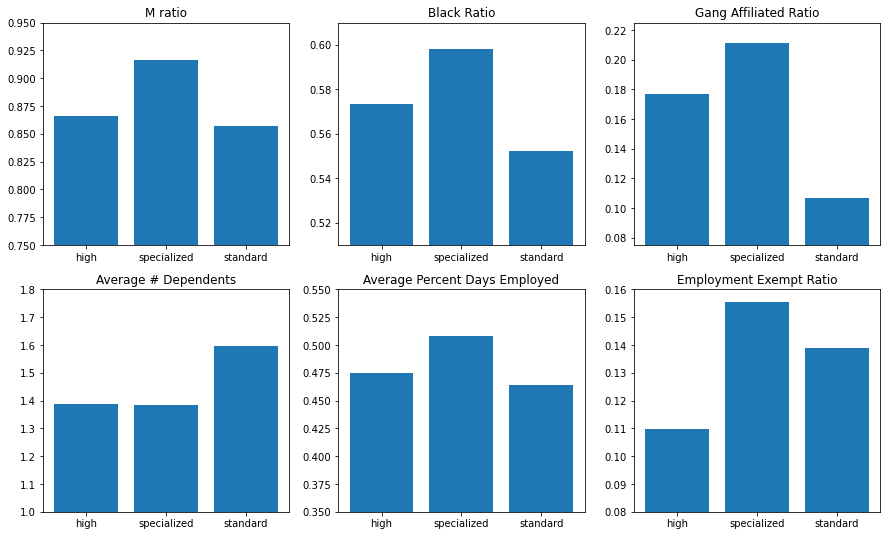

In [42]:
plt.figure(figsize=(15, 9))

plt.subplot(231)
plt.bar(table.index, table['M Ratio'].tolist())
plt.ylim(0.75, 0.95)
plt.title('M ratio')

plt.subplot(232)
plt.bar(table.index, table['Black Ratio'].tolist())
plt.ylim(0.51, 0.61)
plt.title('Black Ratio')

plt.subplot(233)
plt.bar(table.index, table['Gang Affiliated'].tolist())
plt.ylim(0.075, 0.225)
plt.title('Gang Affiliated Ratio')

plt.subplot(234)
plt.bar(table.index, table['Dependents'].tolist())
plt.ylim(1, 1.8)
plt.title('Average # Dependents')

plt.subplot(235)
plt.bar(table.index, table['Percent Days Employed'].tolist())
plt.ylim(0.35, 0.55)
plt.title('Average Percent Days Employed')

plt.subplot(236)
plt.bar(table.index, table['Employment Exempt'].tolist())
plt.ylim(0.08, 0.16)
plt.title('Employment Exempt Ratio')

plt.show()

In [ ]:
t = {'Age_at_Release': [], 'Prison_Years': []}
for df in [data_h, data_spc, data_std]:
    t['Age_at_Release'].append(df.Age_at_Release.value_counts())   
    t['Prison_Years'].append(df.Prison_Years.value_counts())
t['Age_at_Release'][0]

## 分类进行dummy encode

然后做一下回归

In [36]:
cols = data.columns
cols
cols = cols.tolist()

In [37]:
# === 出狱前 ===
cols1 = cols[1: 8]  # personal info
cols1.remove(Y)
cols2 = cols[8: 12]  # prison case info
cols3 = cols[12: 28]  # Criminal History
cols4 = cols[28: 30]  #  Supervision History
cols5 = cols[30: 33]  # Pardons and Paroles Conditions

# === 出狱后 ===
cols6 = cols[33: 49]  # Supervision Activities
cols7 = cols[49:]  # Recidivism Measures

# 3. 